In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Import torch_dxdt
import torch_dxdt

## 1. Generate Test Signal

We'll use a simple sinusoidal signal: $x(t) = \sin(t)$

The analytical derivative is: $\frac{dx}{dt} = \cos(t)$

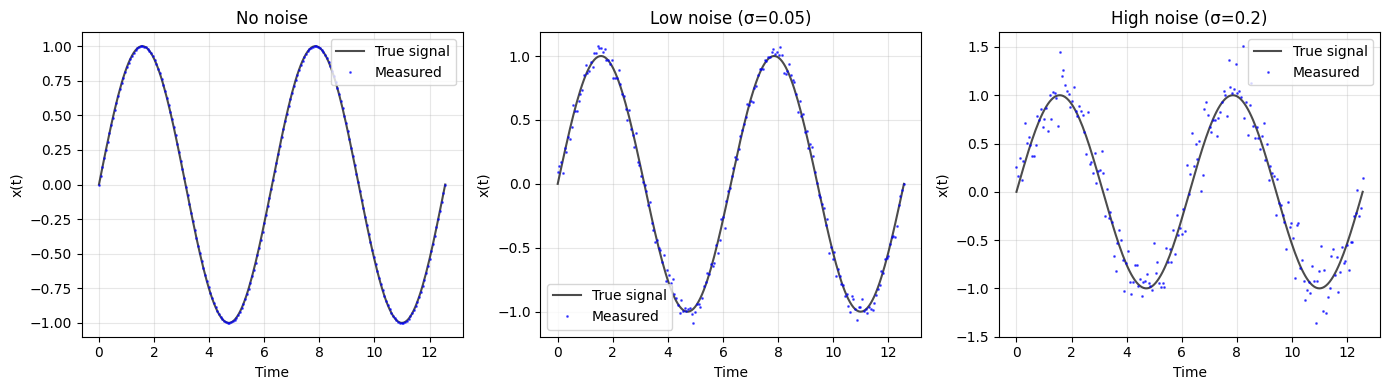

In [2]:
# Time vector
n_points = 200
t = torch.linspace(0, 4 * torch.pi, n_points)

# True signal and derivative
x_true = torch.sin(t)
dx_true = torch.cos(t)

# Different noise levels
noise_levels = {
    "No noise": 0.0,
    "Low noise (σ=0.05)": 0.05,
    "High noise (σ=0.2)": 0.2,
}

# Generate noisy signals
noisy_signals = {}
for name, sigma in noise_levels.items():
    if sigma == 0:
        noisy_signals[name] = x_true.clone()
    else:
        noisy_signals[name] = x_true + sigma * torch.randn_like(x_true)

# Plot the signals
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (name, x_noisy) in zip(axes, noisy_signals.items()):
    ax.plot(t.numpy(), x_true.numpy(), "k-", label="True signal", alpha=0.7)
    ax.plot(t.numpy(), x_noisy.numpy(), "b.", markersize=2, label="Measured", alpha=0.6)
    ax.set_xlabel("Time")
    ax.set_ylabel("x(t)")
    ax.set_title(name)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Define All Methods

We'll compare all seven differentiation methods available in `torch-dxdt`:

In [3]:
# Define all methods with reasonable parameters
methods = {
    "Finite Difference (k=1)": torch_dxdt.FiniteDifference(k=1),
    "Finite Difference (k=2)": torch_dxdt.FiniteDifference(k=2),
    "Savitzky-Golay": torch_dxdt.SavitzkyGolay(window_length=11, polyorder=3),
    "Spectral": torch_dxdt.Spectral(),
    "Spline (s=0.01)": torch_dxdt.Spline(s=0.01),
    "Kernel (GP)": torch_dxdt.Kernel(sigma=0.5, lmbd=0.01),
    "Kalman": torch_dxdt.Kalman(alpha=0.5),
    "Whittaker": torch_dxdt.Whittaker(lmbda=100.0),
}

print(f"Comparing {len(methods)} differentiation methods")

Comparing 8 differentiation methods


## 3. Compare Methods Across Noise Levels

Let's compute derivatives using each method for each noise level and visualize the results:

In [4]:
def compute_derivatives(methods, x, t):
    """Compute derivatives using all methods."""
    results = {}
    for name, method in methods.items():
        try:
            dx = method.d(x, t)
            results[name] = dx
        except Exception as e:
            print(f"Error with {name}: {e}")
            results[name] = None
    return results


def compute_rmse(dx_pred, dx_true):
    """Compute RMSE between predicted and true derivative."""
    if dx_pred is None:
        return float("inf")
    return torch.sqrt(torch.mean((dx_pred - dx_true) ** 2)).item()


# Compute derivatives for all noise levels
all_results = {}
for noise_name, x_noisy in noisy_signals.items():
    all_results[noise_name] = compute_derivatives(methods, x_noisy, t)

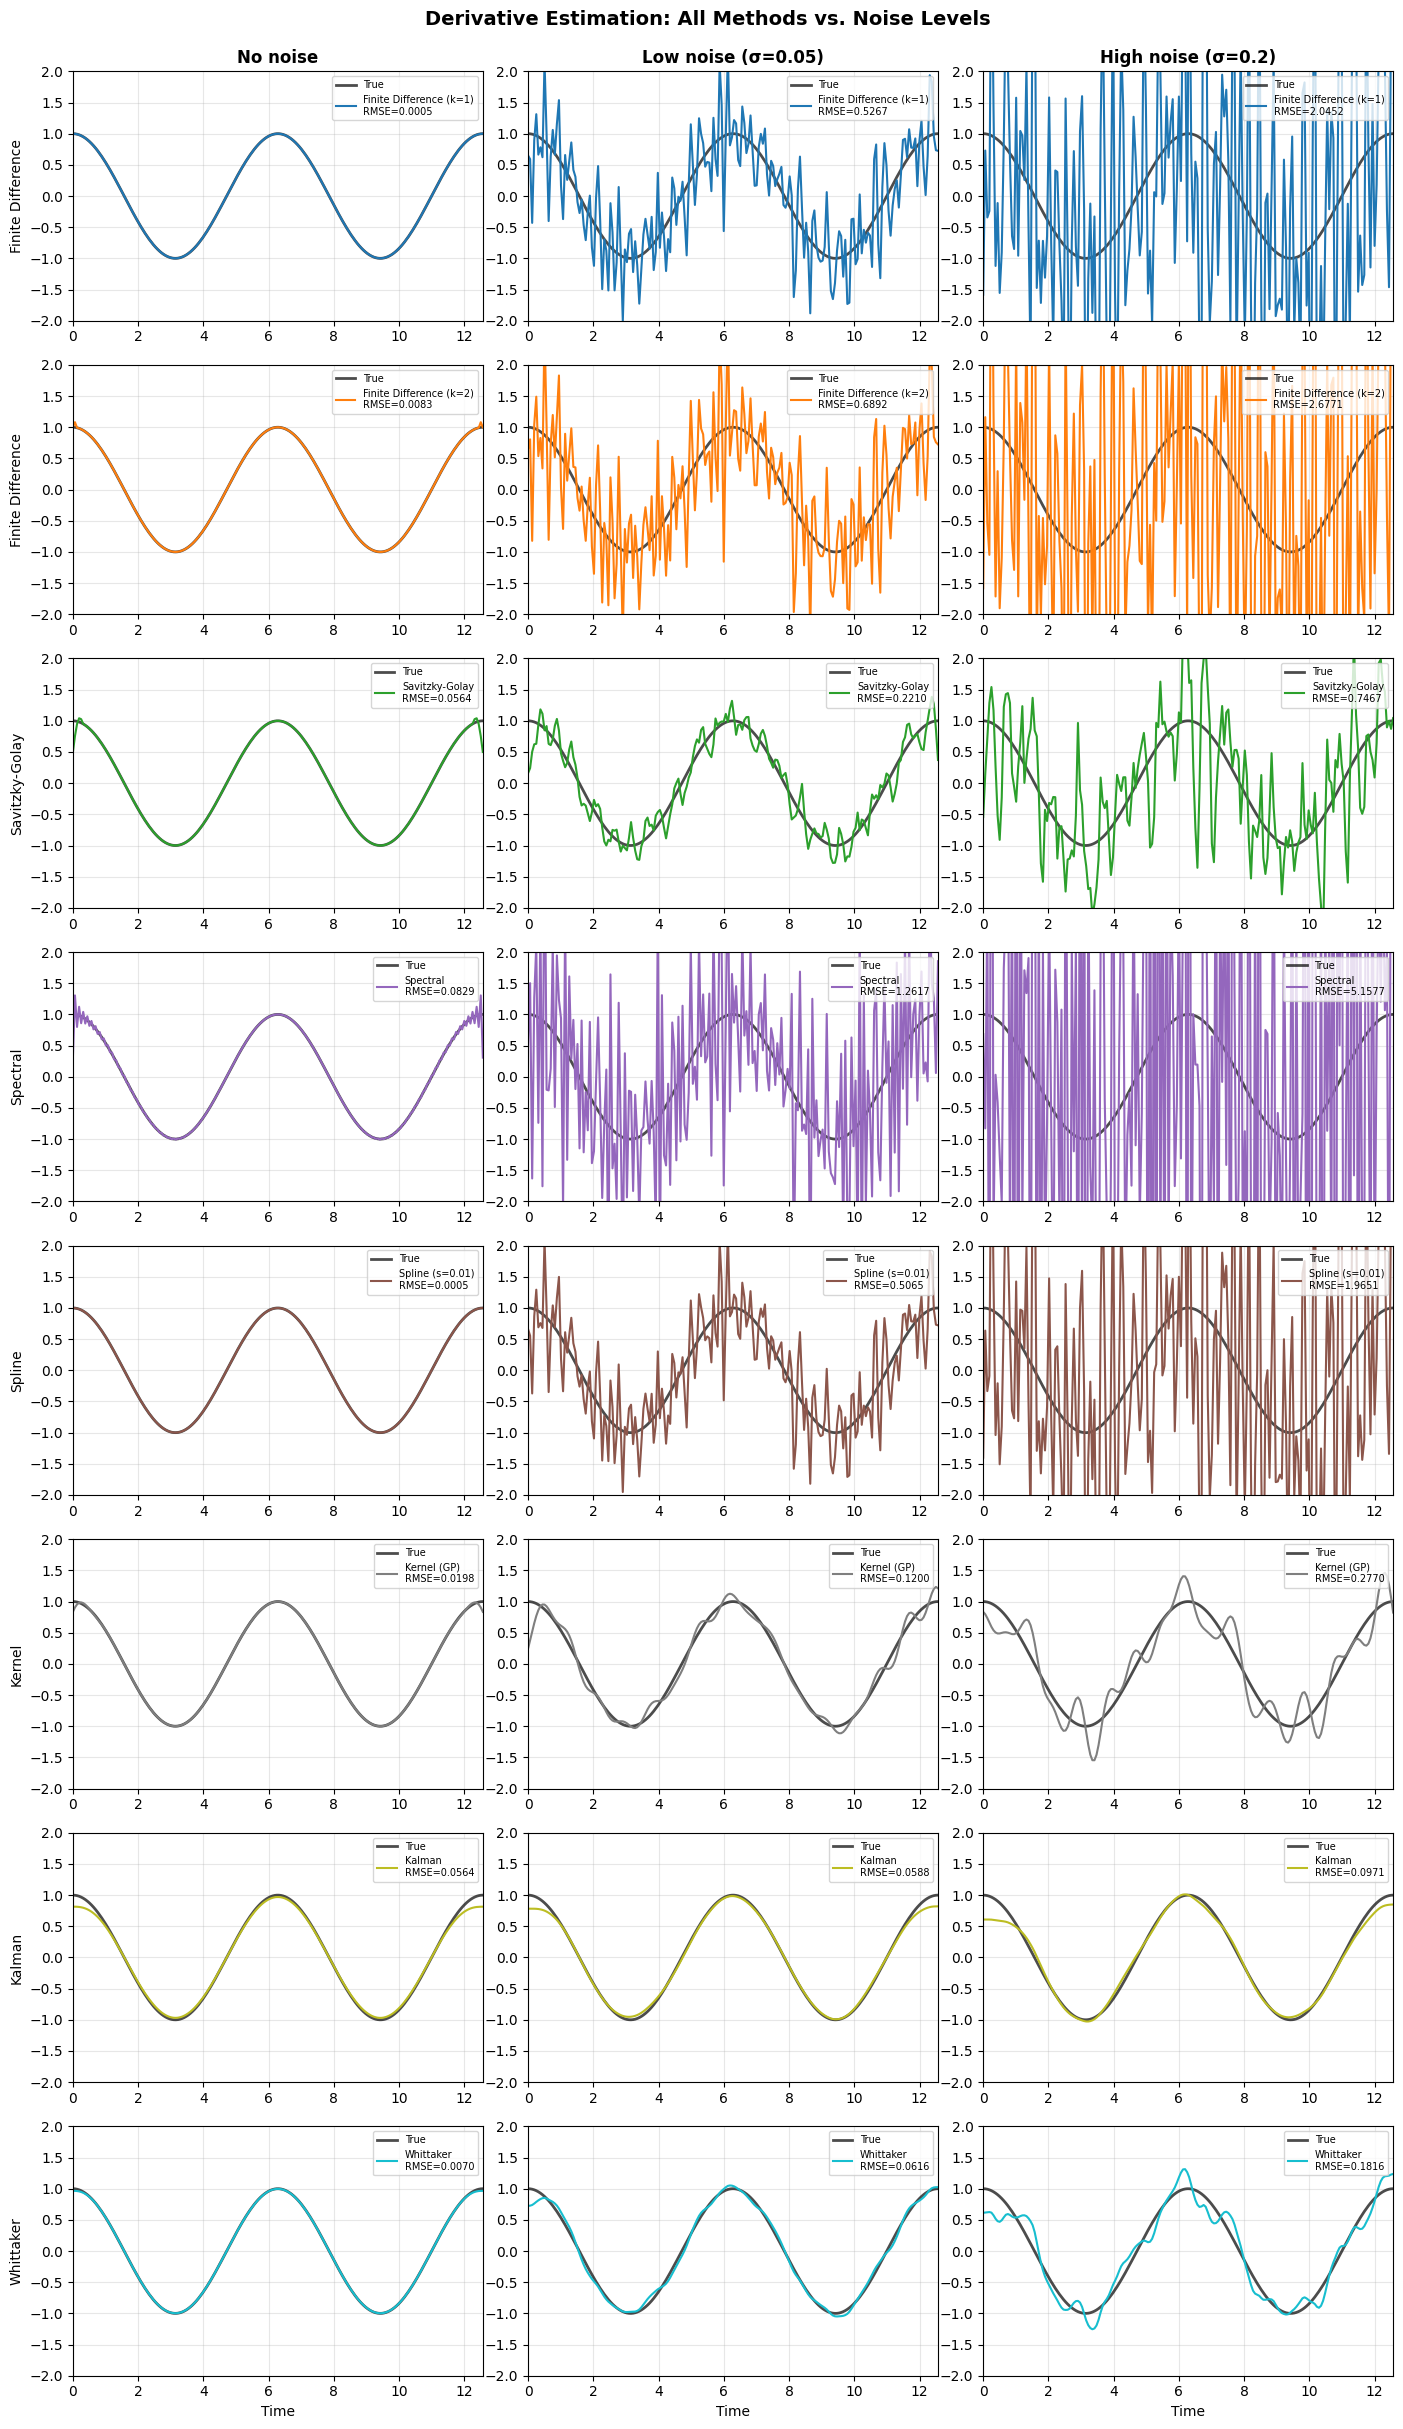

In [5]:
# Create a large comparison plot
n_methods = len(methods)
n_noise = len(noise_levels)

fig, axes = plt.subplots(n_methods, n_noise, figsize=(14, 3 * n_methods))

colors = plt.cm.tab10(np.linspace(0, 1, n_methods))

for j, (noise_name, results) in enumerate(all_results.items()):
    for i, (method_name, dx) in enumerate(results.items()):
        ax = axes[i, j]

        # Plot true derivative
        ax.plot(t.numpy(), dx_true.numpy(), "k-", linewidth=2, label="True", alpha=0.7)

        # Plot computed derivative
        if dx is not None:
            rmse = compute_rmse(dx, dx_true)
            ax.plot(
                t.numpy(),
                dx.numpy(),
                color=colors[i],
                linewidth=1.5,
                label=f"{method_name}\nRMSE={rmse:.4f}",
            )
        else:
            ax.text(0.5, 0.5, "Failed", transform=ax.transAxes, ha="center")

        ax.set_xlim(t[0].item(), t[-1].item())
        ax.set_ylim(-2, 2)
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.set_title(noise_name, fontsize=12, fontweight="bold")
        if j == 0:
            ax.set_ylabel(method_name.split("(")[0].strip(), fontsize=10)
        if i == n_methods - 1:
            ax.set_xlabel("Time")

        ax.legend(loc="upper right", fontsize=7)

plt.tight_layout()
plt.suptitle(
    "Derivative Estimation: All Methods vs. Noise Levels",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.show()

## 4. Quantitative Comparison (RMSE)

Let's create a summary table of RMSE values for each method and noise level:

In [6]:
# Compute RMSE for all combinations
rmse_table = {}
for noise_name, results in all_results.items():
    rmse_table[noise_name] = {}
    for method_name, dx in results.items():
        rmse_table[noise_name][method_name] = compute_rmse(dx, dx_true)

# Display as a formatted table
print("\n" + "=" * 80)
print("RMSE Comparison Table")
print("=" * 80)

# Header
header = f"{'Method':<30}"
for noise_name in noise_levels.keys():
    header += f"{noise_name:<20}"
print(header)
print("-" * 80)

# Rows
for method_name in methods.keys():
    row = f"{method_name:<30}"
    for noise_name in noise_levels.keys():
        rmse = rmse_table[noise_name][method_name]
        row += f"{rmse:<20.6f}"
    print(row)

print("=" * 80)


RMSE Comparison Table
Method                        No noise            Low noise (σ=0.05)  High noise (σ=0.2)  
--------------------------------------------------------------------------------
Finite Difference (k=1)       0.000471            0.526654            2.045237            
Finite Difference (k=2)       0.008328            0.689206            2.677069            
Savitzky-Golay                0.056397            0.221014            0.746678            
Spectral                      0.082896            1.261733            5.157719            
Spline (s=0.01)               0.000472            0.506474            1.965082            
Kernel (GP)                   0.019842            0.119996            0.276997            
Kalman                        0.056355            0.058802            0.097122            
Whittaker                     0.007005            0.061624            0.181598            


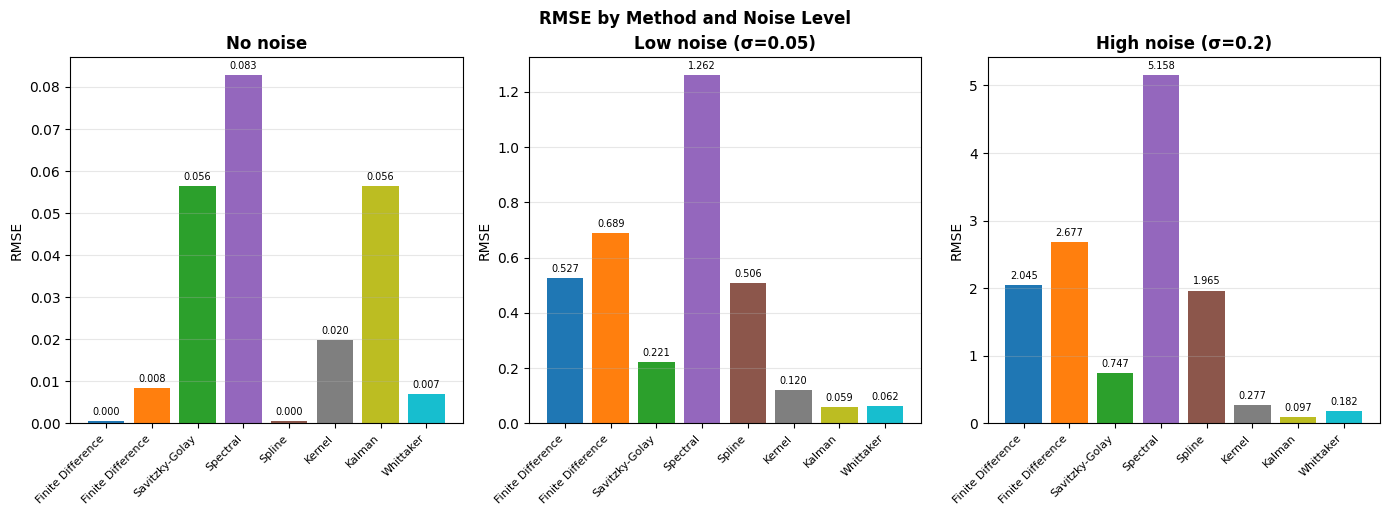

In [7]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

method_names = list(methods.keys())
x_pos = np.arange(len(method_names))

for ax, (noise_name, rmses) in zip(axes, rmse_table.items()):
    values = [rmses[m] for m in method_names]
    bars = ax.bar(x_pos, values, color=colors)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(
        [m.split("(")[0].strip() for m in method_names],
        rotation=45,
        ha="right",
        fontsize=8,
    )
    ax.set_ylabel("RMSE")
    ax.set_title(noise_name, fontweight="bold")
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(
            f"{val:.3f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=7,
        )

plt.tight_layout()
plt.suptitle("RMSE by Method and Noise Level", fontsize=12, fontweight="bold", y=1.02)
plt.show()

## 5. Detailed Analysis: Best Methods for Noisy Data

Let's focus on the high-noise case and tune some methods to see their best performance:

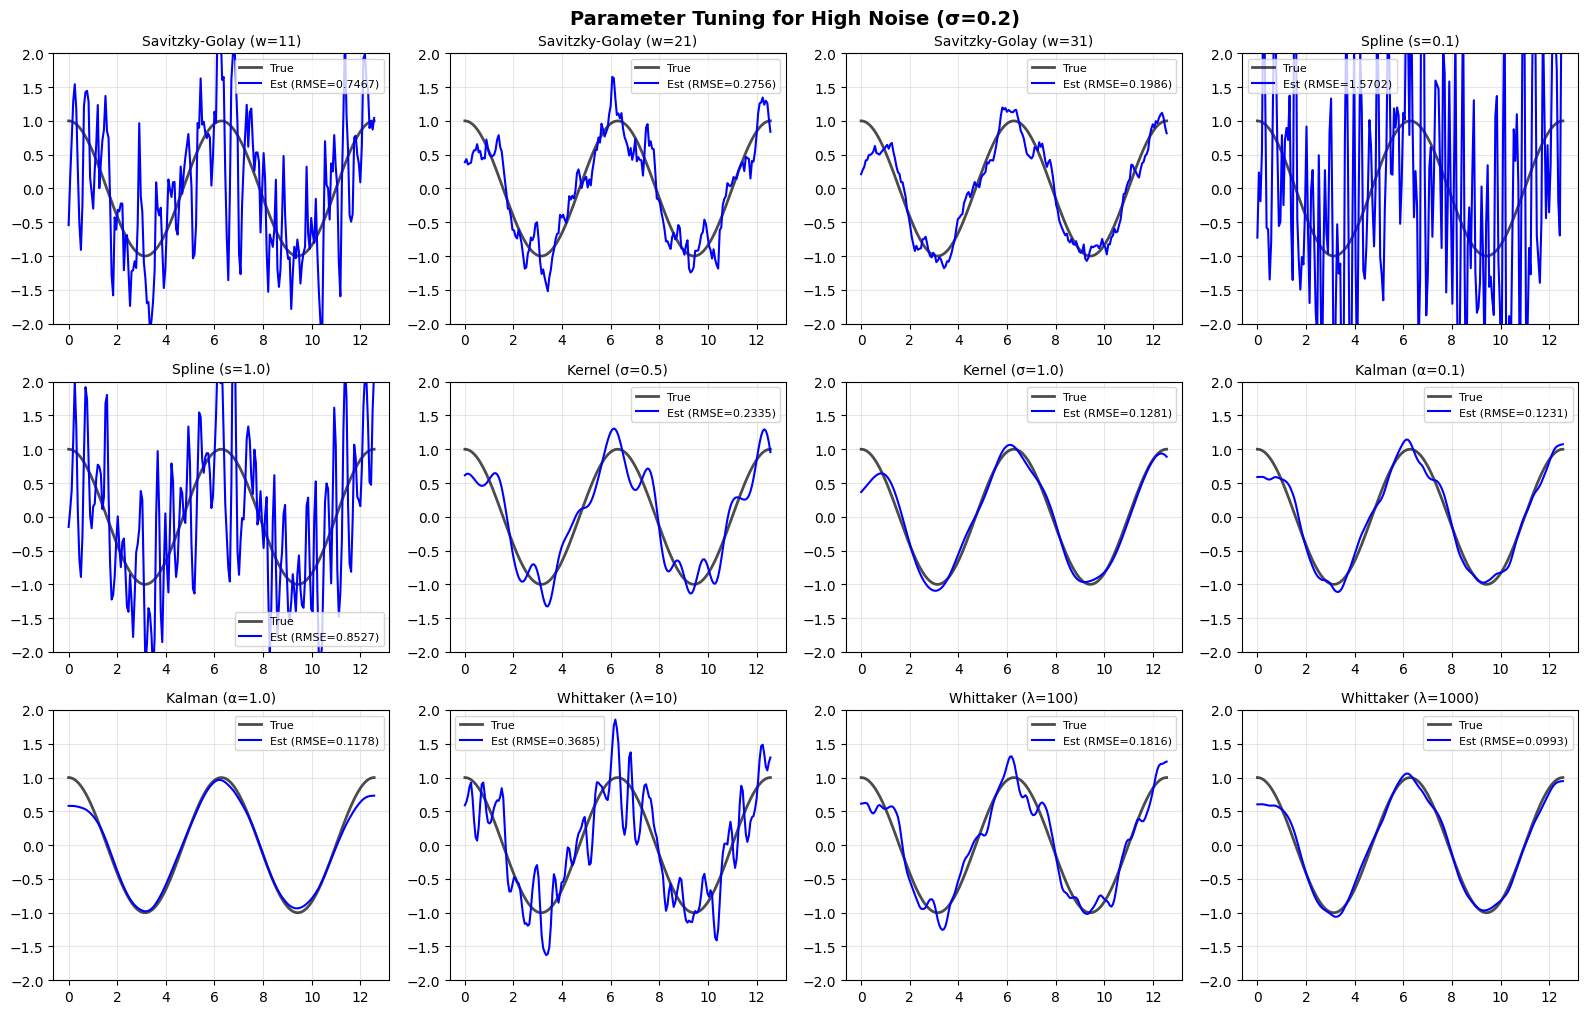

In [8]:
# High noise signal
x_noisy = noisy_signals["High noise (σ=0.2)"]

# Methods optimized for noisy data
noisy_methods = {
    "Savitzky-Golay (w=11)": torch_dxdt.SavitzkyGolay(window_length=11, polyorder=3),
    "Savitzky-Golay (w=21)": torch_dxdt.SavitzkyGolay(window_length=21, polyorder=3),
    "Savitzky-Golay (w=31)": torch_dxdt.SavitzkyGolay(window_length=31, polyorder=3),
    "Spline (s=0.1)": torch_dxdt.Spline(s=0.1),
    "Spline (s=1.0)": torch_dxdt.Spline(s=1.0),
    "Kernel (σ=0.5)": torch_dxdt.Kernel(sigma=0.5, lmbd=0.1),
    "Kernel (σ=1.0)": torch_dxdt.Kernel(sigma=1.0, lmbd=0.1),
    "Kalman (α=0.1)": torch_dxdt.Kalman(alpha=0.1),
    "Kalman (α=1.0)": torch_dxdt.Kalman(alpha=1.0),
    "Whittaker (λ=10)": torch_dxdt.Whittaker(lmbda=10.0),
    "Whittaker (λ=100)": torch_dxdt.Whittaker(lmbda=100.0),
    "Whittaker (λ=1000)": torch_dxdt.Whittaker(lmbda=1000.0),
}

# Compute and plot
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, (name, method) in enumerate(noisy_methods.items()):
    ax = axes[i]
    dx = method.d(x_noisy, t)
    rmse = compute_rmse(dx, dx_true)

    ax.plot(t.numpy(), dx_true.numpy(), "k-", linewidth=2, label="True", alpha=0.7)
    ax.plot(t.numpy(), dx.numpy(), "b-", linewidth=1.5, label=f"Est (RMSE={rmse:.4f})")
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-2, 2)

plt.tight_layout()
plt.suptitle(
    "Parameter Tuning for High Noise (σ=0.2)", fontsize=14, fontweight="bold", y=1.01
)
plt.show()

## 6. Smoothing Comparison

Some methods also provide smoothing capabilities. Let's compare them:

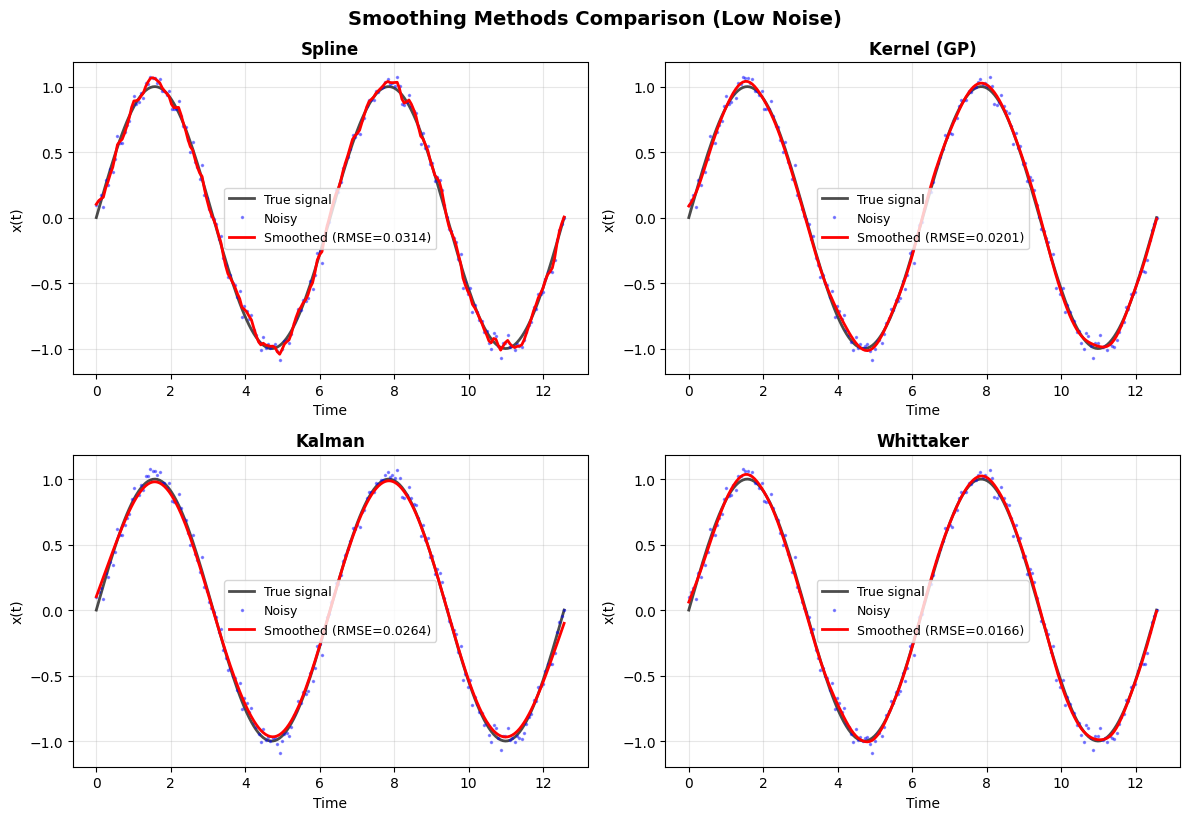

In [9]:
# Methods that support smoothing
smoothing_methods = {
    "Spline": torch_dxdt.Spline(s=0.5),
    "Kernel (GP)": torch_dxdt.Kernel(sigma=0.5, lmbd=0.05),
    "Kalman": torch_dxdt.Kalman(alpha=0.5),
    "Whittaker": torch_dxdt.Whittaker(lmbda=100.0),
}

x_noisy = noisy_signals["Low noise (σ=0.05)"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, method) in zip(axes, smoothing_methods.items()):
    x_smooth = method.smooth(x_noisy, t)
    rmse = compute_rmse(x_smooth, x_true)

    ax.plot(
        t.numpy(), x_true.numpy(), "k-", linewidth=2, label="True signal", alpha=0.7
    )
    ax.plot(t.numpy(), x_noisy.numpy(), "b.", markersize=3, label="Noisy", alpha=0.4)
    ax.plot(
        t.numpy(),
        x_smooth.numpy(),
        "r-",
        linewidth=2,
        label=f"Smoothed (RMSE={rmse:.4f})",
    )
    ax.set_title(name, fontsize=12, fontweight="bold")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Time")
    ax.set_ylabel("x(t)")

plt.tight_layout()
plt.suptitle(
    "Smoothing Methods Comparison (Low Noise)", fontsize=14, fontweight="bold", y=1.02
)
plt.show()

## 7. Computational Efficiency

Let's benchmark the forward and backward pass runtime for each method. Since all methods support PyTorch autograd, we can measure how fast they compute derivatives and gradients.

In [10]:
import time


def benchmark_method(method, x, t, n_runs=50, warmup=5):
    """Benchmark forward and backward pass for a method."""
    # Use requires_grad for backward pass
    x_grad = x.clone().requires_grad_(True)

    # Warmup runs
    for _ in range(warmup):
        dx = method.d(x_grad, t)
        loss = dx.sum()
        loss.backward()
        x_grad.grad = None

    # Benchmark forward pass
    forward_times = []
    for _ in range(n_runs):
        x_grad.grad = None
        start = time.perf_counter()
        dx = method.d(x_grad, t)
        torch.cuda.synchronize() if x.is_cuda else None
        forward_times.append(time.perf_counter() - start)

    # Benchmark backward pass
    backward_times = []
    for _ in range(n_runs):
        x_grad.grad = None
        dx = method.d(x_grad, t)
        loss = dx.sum()
        start = time.perf_counter()
        loss.backward()
        torch.cuda.synchronize() if x.is_cuda else None
        backward_times.append(time.perf_counter() - start)

    return {
        "forward_mean": np.mean(forward_times) * 1000,  # Convert to ms
        "forward_std": np.std(forward_times) * 1000,
        "backward_mean": np.mean(backward_times) * 1000,
        "backward_std": np.std(backward_times) * 1000,
    }


# Benchmark all methods
print("Benchmarking methods (this may take a moment)...")
print(f"Signal length: {n_points} points, {50} runs each\n")

benchmark_results = {}
for name, method in methods.items():
    try:
        results = benchmark_method(method, x_true, t)
        benchmark_results[name] = results
        print(f"✓ {name}")
    except Exception as e:
        print(f"✗ {name}: {e}")
        benchmark_results[name] = None

print("\nBenchmarking complete!")

Benchmarking methods (this may take a moment)...
Signal length: 200 points, 50 runs each

✓ Finite Difference (k=1)
✓ Finite Difference (k=2)
✓ Savitzky-Golay
✓ Spectral
✓ Spline (s=0.01)
✓ Spline (s=0.01)
✓ Kernel (GP)
✓ Kernel (GP)
✓ Kalman
✓ Whittaker

Benchmarking complete!
✓ Kalman
✓ Whittaker

Benchmarking complete!


In [11]:
# Display timing results as a table
print("\n" + "=" * 90)
print("Computational Efficiency (Runtime in milliseconds)")
print("=" * 90)

header = f"{'Method':<30} {'Forward (ms)':<20} {'Backward (ms)':<20} {'Total (ms)':<15}"
print(header)
print("-" * 90)

for name, result in benchmark_results.items():
    if result is not None:
        fwd = f"{result['forward_mean']:.3f} ± {result['forward_std']:.3f}"
        bwd = f"{result['backward_mean']:.3f} ± {result['backward_std']:.3f}"
        total = f"{result['forward_mean'] + result['backward_mean']:.3f}"
        print(f"{name:<30} {fwd:<20} {bwd:<20} {total:<15}")
    else:
        print(f"{name:<30} {'N/A':<20} {'N/A':<20} {'N/A':<15}")

print("=" * 90)


Computational Efficiency (Runtime in milliseconds)
Method                         Forward (ms)         Backward (ms)        Total (ms)     
------------------------------------------------------------------------------------------
Finite Difference (k=1)        0.052 ± 0.010        0.110 ± 0.007        0.162          
Finite Difference (k=2)        0.050 ± 0.002        0.109 ± 0.009        0.159          
Savitzky-Golay                 0.024 ± 0.001        0.046 ± 0.004        0.070          
Spectral                       0.036 ± 0.002        0.053 ± 0.003        0.089          
Spline (s=0.01)                5.999 ± 2.207        0.551 ± 0.037        6.550          
Kernel (GP)                    3.120 ± 0.319        0.326 ± 0.026        3.446          
Kalman                         23.583 ± 9.140       0.175 ± 0.034        23.758         
Whittaker                      1.620 ± 0.133        0.156 ± 0.018        1.776          


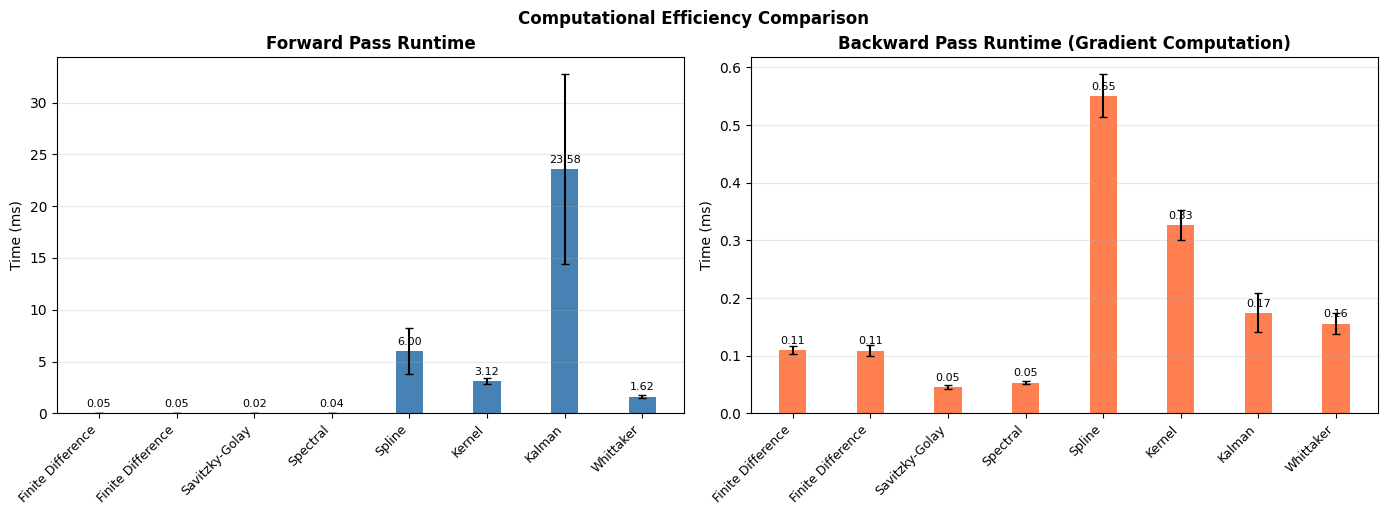

In [12]:
# Visualize timing results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

method_names_short = [m.split("(")[0].strip() for m in benchmark_results.keys()]
forward_times = [r["forward_mean"] if r else 0 for r in benchmark_results.values()]
backward_times = [r["backward_mean"] if r else 0 for r in benchmark_results.values()]
forward_stds = [r["forward_std"] if r else 0 for r in benchmark_results.values()]
backward_stds = [r["backward_std"] if r else 0 for r in benchmark_results.values()]

x_pos = np.arange(len(method_names_short))
width = 0.35

# Forward pass timing
ax1 = axes[0]
bars1 = ax1.bar(
    x_pos,
    forward_times,
    width,
    yerr=forward_stds,
    color="steelblue",
    capsize=3,
    label="Forward",
)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(method_names_short, rotation=45, ha="right", fontsize=9)
ax1.set_ylabel("Time (ms)")
ax1.set_title("Forward Pass Runtime", fontweight="bold")
ax1.grid(True, alpha=0.3, axis="y")

# Add value labels
for bar, val in zip(bars1, forward_times):
    height = bar.get_height()
    ax1.annotate(
        f"{val:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=8,
    )

# Backward pass timing
ax2 = axes[1]
bars2 = ax2.bar(
    x_pos,
    backward_times,
    width,
    yerr=backward_stds,
    color="coral",
    capsize=3,
    label="Backward",
)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(method_names_short, rotation=45, ha="right", fontsize=9)
ax2.set_ylabel("Time (ms)")
ax2.set_title("Backward Pass Runtime (Gradient Computation)", fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

# Add value labels
for bar, val in zip(bars2, backward_times):
    height = bar.get_height()
    ax2.annotate(
        f"{val:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.suptitle(
    "Computational Efficiency Comparison", fontsize=12, fontweight="bold", y=1.02
)
plt.show()

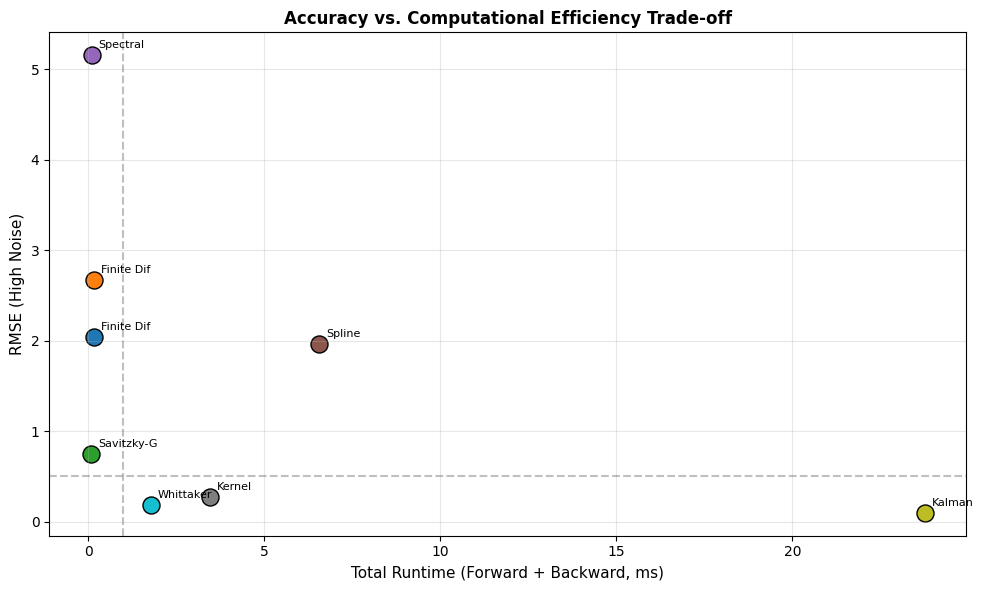


💡 Ideal methods are in the BOTTOM-LEFT corner (fast AND accurate)


In [13]:
# Combined efficiency vs accuracy plot
fig, ax = plt.subplots(figsize=(10, 6))

# Use high noise RMSE for accuracy comparison
noise_key = "High noise (σ=0.2)"

for i, (name, result) in enumerate(benchmark_results.items()):
    if result is not None and name in rmse_table[noise_key]:
        total_time = result["forward_mean"] + result["backward_mean"]
        rmse = rmse_table[noise_key][name]

        ax.scatter(
            total_time,
            rmse,
            s=150,
            c=[colors[i]],
            label=name.split("(")[0].strip(),
            edgecolor="black",
            linewidth=1,
        )
        ax.annotate(
            name.split("(")[0].strip()[:10],
            (total_time, rmse),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
        )

ax.set_xlabel("Total Runtime (Forward + Backward, ms)", fontsize=11)
ax.set_ylabel("RMSE (High Noise)", fontsize=11)
ax.set_title(
    "Accuracy vs. Computational Efficiency Trade-off", fontweight="bold", fontsize=12
)
ax.grid(True, alpha=0.3)

# Add quadrants annotation
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
ax.axvline(
    x=np.median(
        [
            r["forward_mean"] + r["backward_mean"]
            for r in benchmark_results.values()
            if r
        ]
    ),
    color="gray",
    linestyle="--",
    alpha=0.5,
)

plt.tight_layout()
plt.show()

print("\n💡 Ideal methods are in the BOTTOM-LEFT corner (fast AND accurate)")

## 8. Boundary Behavior Comparison

Different methods handle signal boundaries (edges) differently. This is crucial when derivative accuracy at the start or end of your signal matters. Let's compare how each method performs near the boundaries.

In [28]:
# Create a non-periodic signal to highlight boundary effects
torch.manual_seed(42)

# Use a signal that has clear non-zero derivatives at boundaries
n_points = 100
t_boundary = torch.linspace(0, 1, n_points, dtype=torch.float64)

# Exponential signal: x = exp(2t), dx/dt = 2*exp(2t)
x_boundary = torch.exp(2 * t_boundary)
dx_true_boundary = 2 * torch.exp(2 * t_boundary)

# Add a small amount of noise
noise_level = 0.01
x_noisy_boundary = x_boundary + noise_level * x_boundary.max() * torch.randn_like(x_boundary)

print(f"Signal: x = exp(2t)")
print(f"True derivative: dx/dt = 2*exp(2t)")
print(f"Noise level: {noise_level * 100:.1f}% of max signal value")

Signal: x = exp(2t)
True derivative: dx/dt = 2*exp(2t)
Noise level: 1.0% of max signal value


In [20]:
# Compute derivatives with all methods
boundary_methods = {
    "Finite Difference": torch_dxdt.FiniteDifference(k=2),
    "Savitzky-Golay": torch_dxdt.SavitzkyGolay(window_length=11, polyorder=3),
    "Spectral": torch_dxdt.Spectral(),
    "Spline": torch_dxdt.Spline(s=0.001),
    "Kernel": torch_dxdt.Kernel(sigma=0.1, lmbd=0.001),
    "Kalman": torch_dxdt.Kalman(alpha=0.5),
    "Whittaker": torch_dxdt.Whittaker(lmbda=10.0),
}

boundary_results = {}
for name, method in boundary_methods.items():
    dx = method.d(x_noisy_boundary, t_boundary)
    boundary_results[name] = dx

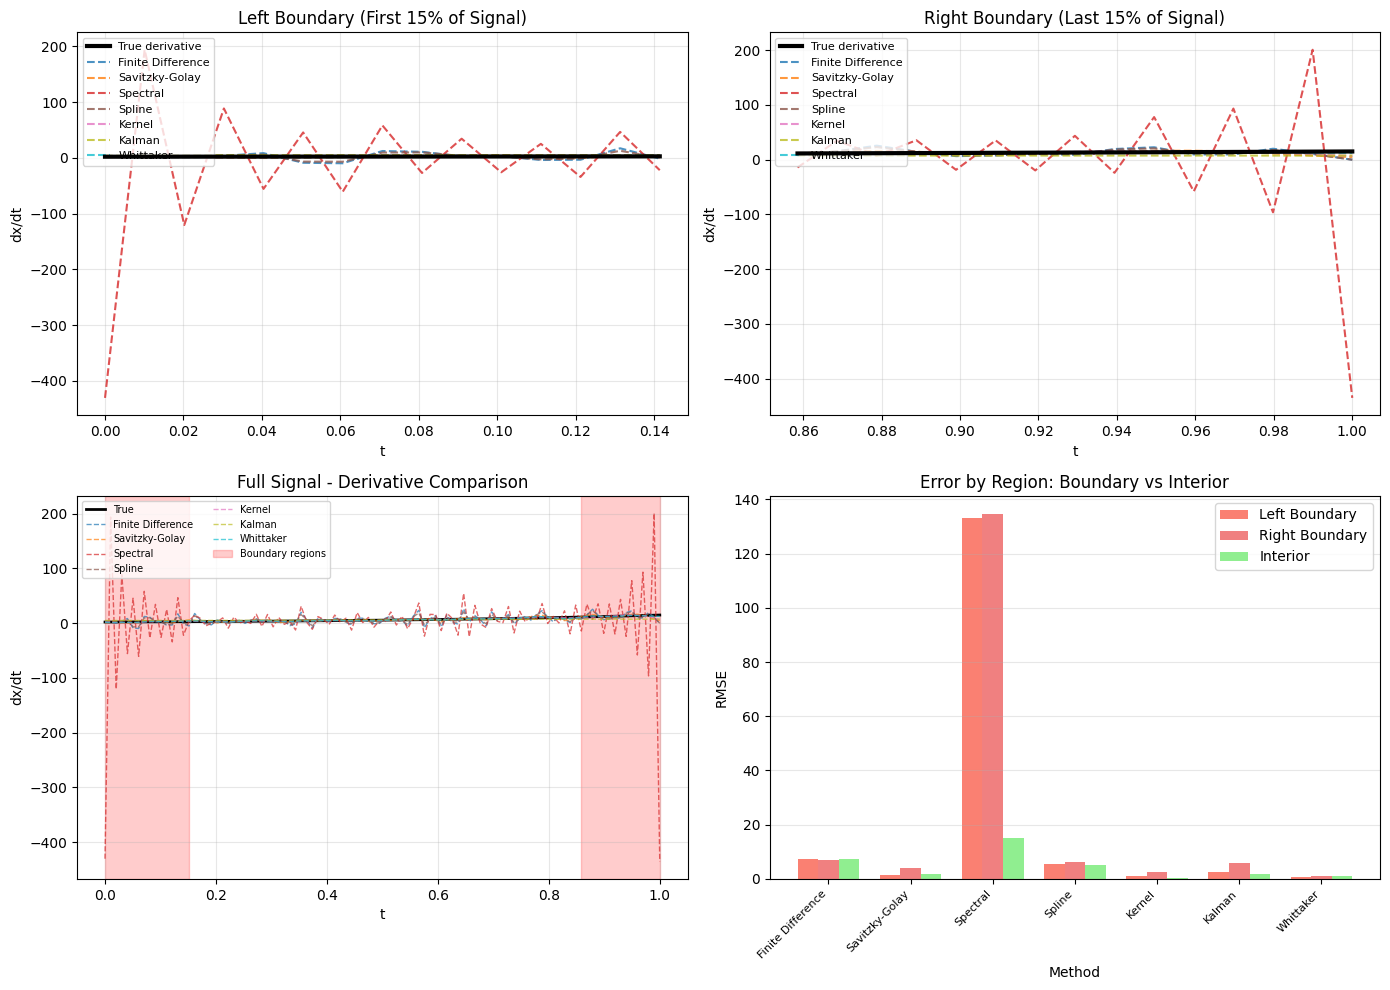

In [21]:
# Visualize boundary behavior - focus on left and right edges
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define edge regions (first and last 15% of points)
edge_size = int(0.15 * n_points)

# Colors for methods
colors = plt.cm.tab10(np.linspace(0, 1, len(boundary_methods)))

# Plot left boundary
ax1 = axes[0, 0]
ax1.plot(t_boundary[:edge_size].numpy(), dx_true_boundary[:edge_size].numpy(), 
         'k-', linewidth=3, label='True derivative', zorder=10)
for (name, dx), color in zip(boundary_results.items(), colors):
    ax1.plot(t_boundary[:edge_size].numpy(), dx[:edge_size].numpy(), 
             '--', color=color, linewidth=1.5, label=name, alpha=0.8)
ax1.set_xlabel('t')
ax1.set_ylabel('dx/dt')
ax1.set_title('Left Boundary (First 15% of Signal)')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot right boundary
ax2 = axes[0, 1]
ax2.plot(t_boundary[-edge_size:].numpy(), dx_true_boundary[-edge_size:].numpy(), 
         'k-', linewidth=3, label='True derivative', zorder=10)
for (name, dx), color in zip(boundary_results.items(), colors):
    ax2.plot(t_boundary[-edge_size:].numpy(), dx[-edge_size:].numpy(), 
             '--', color=color, linewidth=1.5, label=name, alpha=0.8)
ax2.set_xlabel('t')
ax2.set_ylabel('dx/dt')
ax2.set_title('Right Boundary (Last 15% of Signal)')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot full signal with derivatives
ax3 = axes[1, 0]
ax3.plot(t_boundary.numpy(), dx_true_boundary.numpy(), 'k-', linewidth=2, label='True')
for (name, dx), color in zip(boundary_results.items(), colors):
    ax3.plot(t_boundary.numpy(), dx.numpy(), '--', color=color, linewidth=1, label=name, alpha=0.7)
ax3.axvspan(0, t_boundary[edge_size].item(), alpha=0.2, color='red', label='Boundary regions')
ax3.axvspan(t_boundary[-edge_size].item(), 1, alpha=0.2, color='red')
ax3.set_xlabel('t')
ax3.set_ylabel('dx/dt')
ax3.set_title('Full Signal - Derivative Comparison')
ax3.legend(loc='upper left', fontsize=7, ncol=2)
ax3.grid(True, alpha=0.3)

# Compute and plot boundary errors
ax4 = axes[1, 1]
boundary_rmse_left = {}
boundary_rmse_right = {}
interior_rmse = {}

for name, dx in boundary_results.items():
    # Left boundary error
    left_error = torch.sqrt(torch.mean((dx[:edge_size] - dx_true_boundary[:edge_size])**2)).item()
    boundary_rmse_left[name] = left_error
    
    # Right boundary error
    right_error = torch.sqrt(torch.mean((dx[-edge_size:] - dx_true_boundary[-edge_size:])**2)).item()
    boundary_rmse_right[name] = right_error
    
    # Interior error (middle 70%)
    interior_start = edge_size
    interior_end = n_points - edge_size
    interior_error = torch.sqrt(torch.mean((dx[interior_start:interior_end] - dx_true_boundary[interior_start:interior_end])**2)).item()
    interior_rmse[name] = interior_error

# Bar plot of errors
x_pos = np.arange(len(boundary_methods))
width = 0.25

bars1 = ax4.bar(x_pos - width, list(boundary_rmse_left.values()), width, label='Left Boundary', color='salmon')
bars2 = ax4.bar(x_pos, list(boundary_rmse_right.values()), width, label='Right Boundary', color='lightcoral')
bars3 = ax4.bar(x_pos + width, list(interior_rmse.values()), width, label='Interior', color='lightgreen')

ax4.set_xlabel('Method')
ax4.set_ylabel('RMSE')
ax4.set_title('Error by Region: Boundary vs Interior')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(list(boundary_methods.keys()), rotation=45, ha='right', fontsize=8)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [22]:
# Print summary table of boundary behavior
print("\n" + "=" * 70)
print("Boundary Behavior Summary (RMSE)")
print("=" * 70)
print(f"\n{'Method':<20} {'Left Boundary':<15} {'Right Boundary':<15} {'Interior':<15} {'Boundary/Interior Ratio':<10}")
print("-" * 70)

for name in boundary_methods.keys():
    left = boundary_rmse_left[name]
    right = boundary_rmse_right[name]
    interior = interior_rmse[name]
    avg_boundary = (left + right) / 2
    ratio = avg_boundary / interior if interior > 0 else float('inf')
    print(f"{name:<20} {left:<15.4f} {right:<15.4f} {interior:<15.4f} {ratio:<10.2f}x")

print("\n" + "=" * 70)
print("\n📊 Interpretation:")
print("- Lower RMSE is better")
print("- Boundary/Interior Ratio > 1 means boundaries are less accurate than interior")
print("- Spectral has poor boundary behavior for non-periodic signals")
print("- Global methods (Spline, Kalman, Kernel) typically have better boundary behavior")
print("- Local methods (Savitzky-Golay, Finite Difference) struggle at boundaries")


Boundary Behavior Summary (RMSE)

Method               Left Boundary   Right Boundary  Interior        Boundary/Interior Ratio
----------------------------------------------------------------------
Finite Difference    7.2523          7.0180          7.2586          0.98      x
Savitzky-Golay       1.5608          3.9214          1.8832          1.46      x
Spectral             133.0520        134.5661        15.0629         8.88      x
Spline               5.4102          6.1077          5.1848          1.11      x
Kernel               0.8867          2.6514          0.4013          4.41      x
Kalman               2.5887          5.7184          1.6375          2.54      x
Whittaker            0.7787          1.0617          0.9035          1.02      x


📊 Interpretation:
- Lower RMSE is better
- Boundary/Interior Ratio > 1 means boundaries are less accurate than interior
- Spectral has poor boundary behavior for non-periodic signals
- Global methods (Spline, Kalman, Kernel) typical

### Savitzky-Golay Padding Strategies

Savitzky-Golay uses padding to handle boundaries. The `pad_mode` parameter controls the padding strategy:

- **`'replicate'`** (default): Repeats the edge value - good for monotonic signals
- **`'reflect'`**: Reflects/mirrors the signal at the boundary - good for symmetric signals
- **`'circular'`**: Wraps around - **only for periodic signals!**

```python
# Example usage:
sg = torch_dxdt.SavitzkyGolay(window_length=11, polyorder=3, pad_mode='reflect')
```

In [40]:
# Compare Savitzky-Golay with different padding modes using the native pad_mode parameter
# Available modes: 'replicate' (default), 'reflect', 'circular'

padding_modes = ['replicate', 'reflect', 'circular']
padding_results = {}

for mode in padding_modes:
    # Use the native pad_mode parameter
    sg = torch_dxdt.SavitzkyGolay(window_length=11, polyorder=3, pad_mode=mode)
    dx = sg.d(x_noisy_boundary, t_boundary)
    padding_results[mode] = dx

print("Computed Savitzky-Golay derivatives with different padding modes:")
print(f"  Available modes: {torch_dxdt.SavitzkyGolay.VALID_PAD_MODES}")

Computed Savitzky-Golay derivatives with different padding modes:
  Available modes: ('replicate', 'reflect', 'circular')


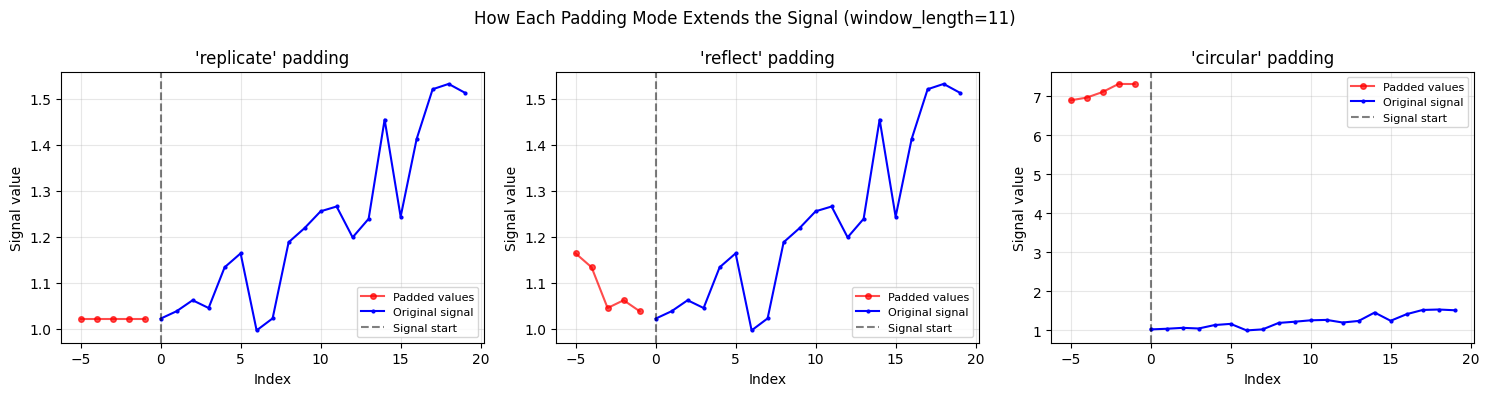


💡 Key insight:
   - For an exponentially growing signal, 'replicate' holds the edge value constant
   - 'reflect' mirrors the growth, creating a V-shape that can cause artifacts
   - 'circular' wraps to the END of the signal, creating huge discontinuities


In [41]:
# Visualize how each padding mode affects the boundary region
# This helps understand why certain modes perform better/worse

import torch.nn.functional as F

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

window_length = 11
pad_size = window_length // 2

# Get a view of the signal near the left boundary
left_region = 20  # Show first 20 points plus padding

for ax, mode in zip(axes, ['replicate', 'reflect', 'circular']):
    # Pad the signal
    x_conv = x_noisy_boundary.unsqueeze(0).unsqueeze(0)
    x_padded = F.pad(x_conv, (pad_size, pad_size), mode=mode).squeeze()
    
    # Plot padded region (before original signal starts)
    pad_x = np.arange(-pad_size, 0)
    ax.plot(pad_x, x_padded[:pad_size].numpy(), 'ro-', markersize=4, label='Padded values', alpha=0.7)
    
    # Plot original signal (first few points)
    orig_x = np.arange(0, left_region)
    ax.plot(orig_x, x_padded[pad_size:pad_size+left_region].numpy(), 'b.-', markersize=4, label='Original signal')
    
    # Mark the boundary
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.5, label='Signal start')
    
    ax.set_xlabel('Index')
    ax.set_ylabel('Signal value')
    ax.set_title(f"'{mode}' padding")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'How Each Padding Mode Extends the Signal (window_length={window_length})', fontsize=12)
plt.tight_layout()
plt.show()

print("\n💡 Key insight:")
print("   - For an exponentially growing signal, 'replicate' holds the edge value constant")
print("   - 'reflect' mirrors the growth, creating a V-shape that can cause artifacts")
print("   - 'circular' wraps to the END of the signal, creating huge discontinuities")

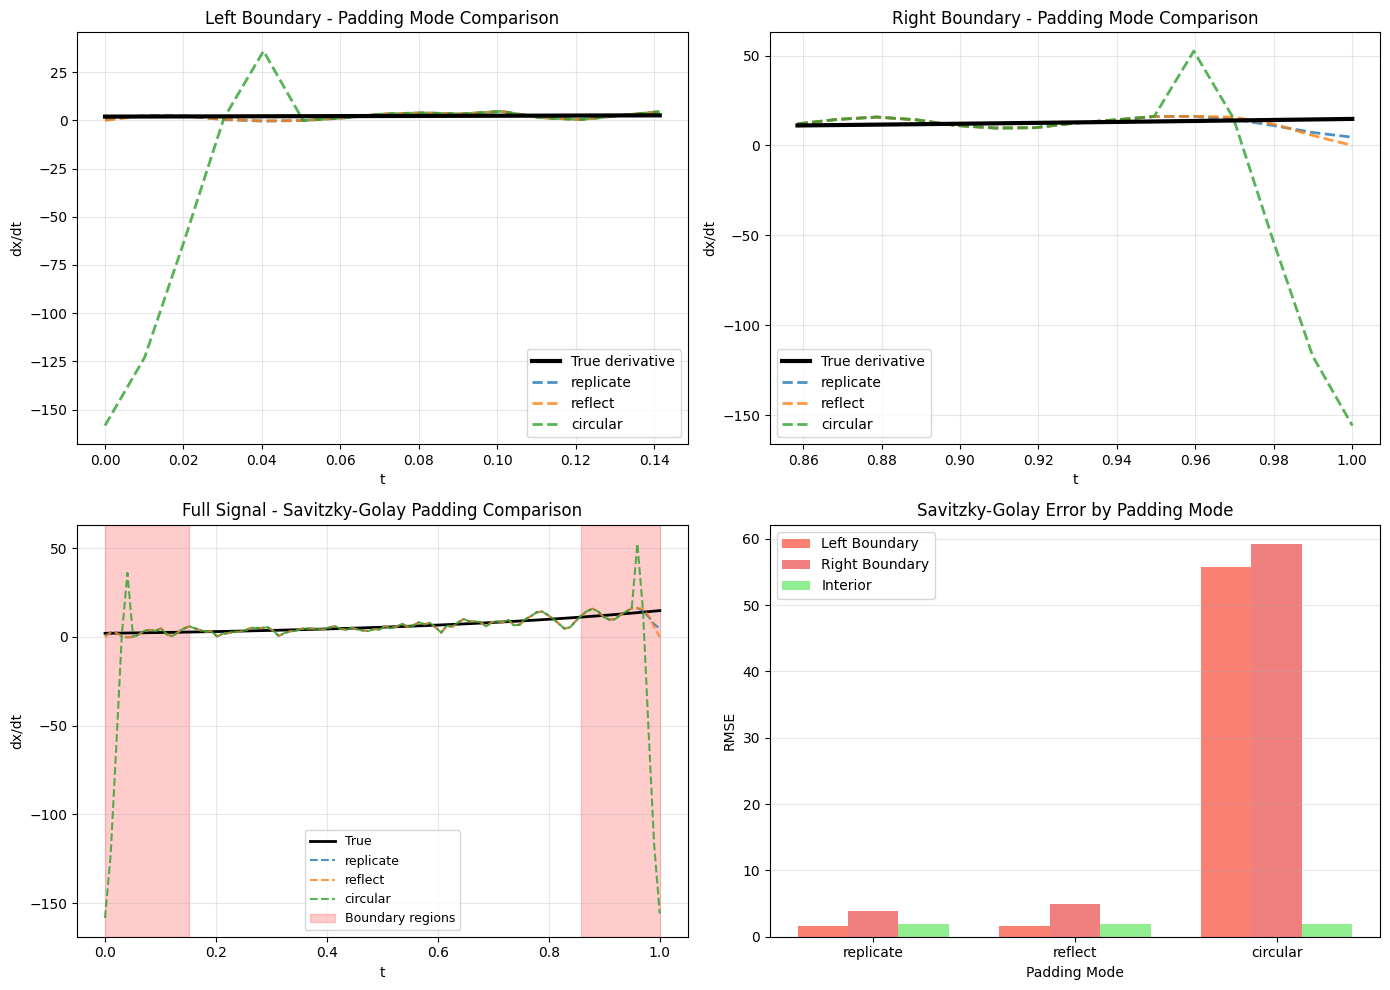

In [42]:
# Visualize padding mode comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Colors for padding modes
pad_colors = {'replicate': 'tab:blue', 'reflect': 'tab:orange', 'circular': 'tab:green',
              'default (replicate)': 'tab:blue', 'periodic (circular)': 'tab:green'}

# Focus on showing unique modes (replicate, reflect, circular)
unique_modes = ['replicate', 'reflect', 'circular']

# Left boundary comparison
ax1 = axes[0, 0]
ax1.plot(t_boundary[:edge_size].numpy(), dx_true_boundary[:edge_size].numpy(), 
         'k-', linewidth=3, label='True derivative', zorder=10)
for mode in unique_modes:
    dx = padding_results[mode]
    ax1.plot(t_boundary[:edge_size].numpy(), dx[:edge_size].numpy(), 
             '--', linewidth=2, label=f'{mode}', alpha=0.8)
ax1.set_xlabel('t')
ax1.set_ylabel('dx/dt')
ax1.set_title('Left Boundary - Padding Mode Comparison')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right boundary comparison
ax2 = axes[0, 1]
ax2.plot(t_boundary[-edge_size:].numpy(), dx_true_boundary[-edge_size:].numpy(), 
         'k-', linewidth=3, label='True derivative', zorder=10)
for mode in unique_modes:
    dx = padding_results[mode]
    ax2.plot(t_boundary[-edge_size:].numpy(), dx[-edge_size:].numpy(), 
             '--', linewidth=2, label=f'{mode}', alpha=0.8)
ax2.set_xlabel('t')
ax2.set_ylabel('dx/dt')
ax2.set_title('Right Boundary - Padding Mode Comparison')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Full signal
ax3 = axes[1, 0]
ax3.plot(t_boundary.numpy(), dx_true_boundary.numpy(), 'k-', linewidth=2, label='True')
for mode in unique_modes:
    dx = padding_results[mode]
    ax3.plot(t_boundary.numpy(), dx.numpy(), '--', linewidth=1.5, label=f'{mode}', alpha=0.8)
ax3.axvspan(0, t_boundary[edge_size].item(), alpha=0.2, color='red', label='Boundary regions')
ax3.axvspan(t_boundary[-edge_size].item(), 1, alpha=0.2, color='red')
ax3.set_xlabel('t')
ax3.set_ylabel('dx/dt')
ax3.set_title('Full Signal - Savitzky-Golay Padding Comparison')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Error comparison
ax4 = axes[1, 1]
padding_errors = {}
for mode in unique_modes:
    dx = padding_results[mode]
    left_err = torch.sqrt(torch.mean((dx[:edge_size] - dx_true_boundary[:edge_size])**2)).item()
    right_err = torch.sqrt(torch.mean((dx[-edge_size:] - dx_true_boundary[-edge_size:])**2)).item()
    interior_err = torch.sqrt(torch.mean((dx[edge_size:-edge_size] - dx_true_boundary[edge_size:-edge_size])**2)).item()
    padding_errors[mode] = {'left': left_err, 'right': right_err, 'interior': interior_err}

x_pos = np.arange(len(unique_modes))
width = 0.25
bars1 = ax4.bar(x_pos - width, [padding_errors[m]['left'] for m in unique_modes], width, label='Left Boundary', color='salmon')
bars2 = ax4.bar(x_pos, [padding_errors[m]['right'] for m in unique_modes], width, label='Right Boundary', color='lightcoral')
bars3 = ax4.bar(x_pos + width, [padding_errors[m]['interior'] for m in unique_modes], width, label='Interior', color='lightgreen')

ax4.set_xlabel('Padding Mode')
ax4.set_ylabel('RMSE')
ax4.set_title('Savitzky-Golay Error by Padding Mode')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(unique_modes)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [43]:
# Print padding comparison summary
print("\n" + "=" * 60)
print("Savitzky-Golay Padding Mode Comparison (RMSE)")
print("=" * 60)
print(f"\n{'Padding Mode':<15} {'Left Boundary':<15} {'Right Boundary':<15} {'Interior':<15}")
print("-" * 60)

for mode in unique_modes:
    e = padding_errors[mode]
    print(f"{mode:<15} {e['left']:<15.4f} {e['right']:<15.4f} {e['interior']:<15.4f}")

# Find best mode for each region
best_left = min(unique_modes, key=lambda m: padding_errors[m]['left'])
best_right = min(unique_modes, key=lambda m: padding_errors[m]['right'])
best_overall = min(unique_modes, key=lambda m: (padding_errors[m]['left'] + padding_errors[m]['right']) / 2)

print("\n" + "=" * 60)
print("\n📊 Results:")
print(f"   - Best for left boundary:  {best_left}")
print(f"   - Best for right boundary: {best_right}")
print(f"   - Best overall:            {best_overall}")
print("\n💡 Key Insights:")
print("   - 'circular' mode is ONLY for truly periodic signals - catastrophic for non-periodic!")
print("   - 'replicate' works well for monotonic signals (like exponential)")
print("   - 'reflect' may work better for signals with local symmetry near edges")
print("   - The best padding mode depends on your signal's characteristics")
print("   - For best results, consider trimming boundary points from results")


Savitzky-Golay Padding Mode Comparison (RMSE)

Padding Mode    Left Boundary   Right Boundary  Interior       
------------------------------------------------------------
replicate       1.5608          3.9214          1.8832         
reflect         1.5769          4.9665          1.8832         
circular        55.7651         59.1305         1.8832         


📊 Results:
   - Best for left boundary:  replicate
   - Best for right boundary: replicate
   - Best overall:            replicate

💡 Key Insights:
   - 'circular' mode is ONLY for truly periodic signals - catastrophic for non-periodic!
   - 'replicate' works well for monotonic signals (like exponential)
   - 'reflect' may work better for signals with local symmetry near edges
   - The best padding mode depends on your signal's characteristics
   - For best results, consider trimming boundary points from results


### Boundary Behavior Recommendations

Based on the analysis above:

| Boundary Quality | Methods | Notes |
|-----------------|---------|-------|
| ⭐ **Excellent** | Spectral | Only for periodic signals! |
| ✅ **Good** | Spline, Kalman, Kernel, Whittaker | Global/smoothing methods handle edges well |
| ⚠️ **Moderate** | Finite Difference, Savitzky-Golay | Local methods have more edge artifacts |

**Savitzky-Golay Padding Strategy:**
- **`replicate`** (default): Safe choice for monotonic or slowly-varying signals
- **`reflect`**: May help signals with local symmetry at boundaries
- **`circular`**: **Only use for truly periodic signals!** Catastrophic for non-periodic data

**Key Takeaways:**
- **For non-periodic signals where boundaries matter**: Use `Spline`, `Kalman`, `Kernel`, or `Whittaker`
- **For periodic signals**: Use `Spectral` (perfect boundary handling by design)
- **If using Savitzky-Golay**: The default `replicate` mode is usually safest
- **General advice**: Consider trimming a few points from each edge of results for local methods

## 9. Summary and Recommendations

Based on the comparisons above, here are some general guidelines:

### For Clean Data (No/Low Noise):
- **Spectral** method works extremely well for periodic signals
- **Finite Difference** is simple, effective, and **fastest**
- **Savitzky-Golay** with small window is accurate

### For Noisy Data:
- **Savitzky-Golay** with larger window provides good smoothing
- **Whittaker-Eilers** offers excellent global smoothing with tunable λ
- **Kernel (GP)** provides probabilistic smoothing
- **Kalman** is good for sequential/online estimation
- **Spline** with appropriate smoothing parameter

### Computational Efficiency:
- **Fastest**: Finite Difference, Savitzky-Golay (simple convolution operations)
- **Moderate**: Spectral (FFT-based), Kalman (sequential operations)
- **Slower**: Whittaker, Spline, Kernel (matrix operations/inversions)

### Best Trade-off (Accuracy vs Speed):
- **Kalman** and **Whittaker** offer the best balance of accuracy and efficiency for noisy data
- **Savitzky-Golay** is very fast with good accuracy when properly tuned

### Boundary Behavior:
- **Best boundaries**: Spline, Kalman, Kernel (global methods)
- **Periodic signals**: Spectral is perfect
- **If using Savitzky-Golay**: Try `reflect` padding mode for better edges

### Key Parameters to Tune:
- **Savitzky-Golay**: `window_length` (larger = smoother), padding mode for boundaries
- **Whittaker**: `lmbda` (larger = smoother)
- **Spline**: `s` (larger = smoother)
- **Kernel**: `sigma` (kernel width) and `lmbd` (noise variance)
- **Kalman**: `alpha` (process noise)

In [14]:
# Final summary: Best method for each noise level
print("\n" + "=" * 60)
print("Best Methods by Noise Level (Lowest RMSE)")
print("=" * 60)

for noise_name, rmses in rmse_table.items():
    best_method = min(rmses.items(), key=lambda x: x[1])
    print(f"\n{noise_name}:")
    print(f"  Best: {best_method[0]} (RMSE = {best_method[1]:.6f})")

    # Top 3
    sorted_methods = sorted(rmses.items(), key=lambda x: x[1])
    print("  Top 3:")
    for i, (method, rmse) in enumerate(sorted_methods[:3], 1):
        print(f"    {i}. {method}: RMSE = {rmse:.6f}")

print("\n" + "=" * 60)


Best Methods by Noise Level (Lowest RMSE)

No noise:
  Best: Finite Difference (k=1) (RMSE = 0.000471)
  Top 3:
    1. Finite Difference (k=1): RMSE = 0.000471
    2. Spline (s=0.01): RMSE = 0.000472
    3. Whittaker: RMSE = 0.007005

Low noise (σ=0.05):
  Best: Kalman (RMSE = 0.058802)
  Top 3:
    1. Kalman: RMSE = 0.058802
    2. Whittaker: RMSE = 0.061624
    3. Kernel (GP): RMSE = 0.119996

High noise (σ=0.2):
  Best: Kalman (RMSE = 0.097122)
  Top 3:
    1. Kalman: RMSE = 0.097122
    2. Whittaker: RMSE = 0.181598
    3. Kernel (GP): RMSE = 0.276997

